In [1]:
pip install pykalman

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 2.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
dig = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/DIG Historical Data 1_6.csv')
dxg = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/DXG Historical Data 1_6.csv')
nvl = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/NVL Historical Data 1_6.csv')

In [5]:
dig['Price'] = dig['Price'].str.replace('$', '', regex=True)
dig['Price'] = dig['Price'].str.replace(',', '', regex=True)
dig['Price'] = dig.Price.astype(float)
dig['Date'] = pd.to_datetime(dig['Date'])
dig=dig[::-1]

dxg['Price'] = dxg['Price'].str.replace('$', '', regex=True)
dxg['Price'] = dxg['Price'].str.replace(',', '', regex=True)
dxg['Price'] = dxg.Price.astype(float)
dxg['Date'] = pd.to_datetime(dxg['Date'])
dxg=dxg[::-1]

nvl['Price'] = nvl['Price'].str.replace('$', '', regex=True)
nvl['Price'] = nvl['Price'].str.replace(',', '', regex=True)
nvl['Price'] = nvl.Price.astype(float)
nvl['Date'] = pd.to_datetime(nvl['Date'])
nvl=nvl[::-1]

In [6]:
dig.set_index('Date', inplace=True)
dxg.set_index('Date', inplace=True)
nvl.set_index('Date', inplace=True)

<Axes: xlabel='Date'>

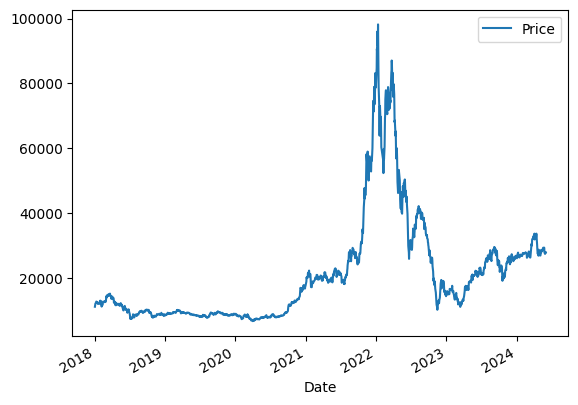

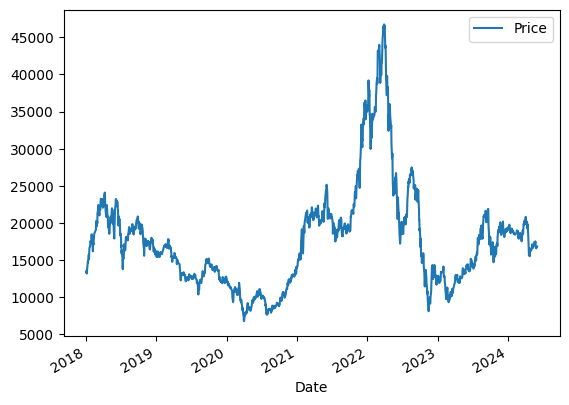

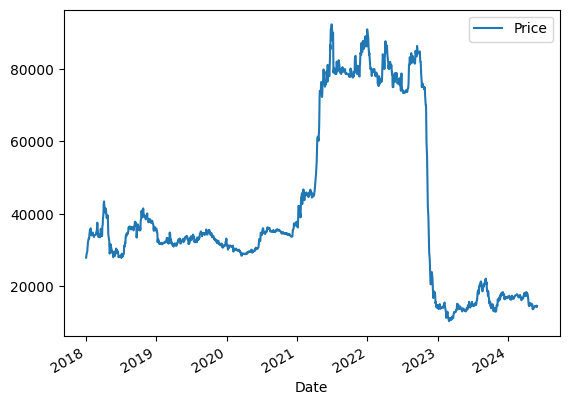

In [7]:
dig.plot()
dxg.plot()
nvl.plot()

In [8]:
#Chuẩn hóa dữ liệu
df1=dig.reset_index()['Price']
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [9]:
#Chia train test 8:2
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [10]:
#Chuyển mảng giá trị thành ma trận 2D
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [11]:
#time_step = 6 tháng(khoảng 180 ngày)
time_step = 180
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest= create_dataset(test_data, time_step)

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)

(1097, 180)
(1097,)
(139, 180)
(139,)


In [13]:
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=X_train[0][0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)

In [14]:
#tìm thông số phù hợp cho mô hình (giống auto arima)
kf = kf.em(X_train[0])

In [15]:
test_data.shape

(320, 1)

In [16]:
test_observed = test_data
#Sử dụng phương thức filter của mô hình Kalman Filter (kf) để dự đoán các giá trị trong test_observed
test_predicted, _ = kf.filter(test_observed)

In [17]:
test_predicted.shape

(320, 1)

In [18]:
#Chuyển đổi giá trị chuẩn hóa về dạng ban đầu
test_predicted=scaler.inverse_transform(test_predicted)
ytest=ytest.reshape(-1,1)
ytest=scaler.inverse_transform(test_data)

In [19]:
test_rmse = np.sqrt(np.mean((test_predicted - ytest)**2))
test_mae = mean_absolute_error(test_predicted, ytest)
test_mape = np.mean(np.abs(test_predicted - ytest)/np.abs(test_predicted))*100

In [20]:
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 281.1848759883584
Testing MAPE: 0.8631067844695519
Testing MAE: 189.29568080577653


In [21]:
x_input=test_data[60:].reshape(1,-1)
x_input.shape[1]

260

In [22]:
test_data[60:].shape

(260, 1)

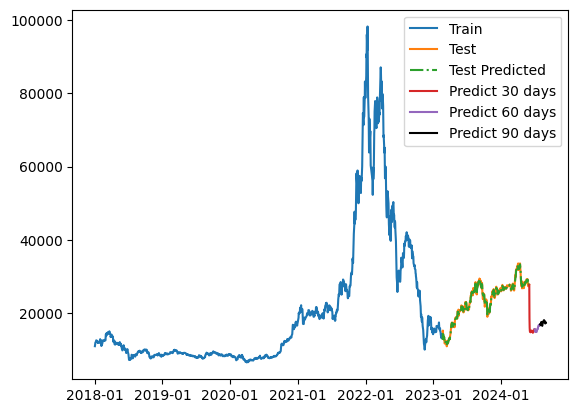

In [23]:
def forecast_days(kf, x_input, n_steps, days):
    """
    Hàm dự báo số ngày tiếp theo.

    :param kf: Mô hình Kalman Filter đã được huấn luyện.
    :param x_input: Dữ liệu đầu vào để bắt đầu dự báo.
    :param n_steps: Số bước thời gian sử dụng trong mô hình.
    :param days: Số ngày cần dự báo.

    :return: Dự báo cho số ngày tiếp theo.
    """
    temp_input = list(x_input)
    temp_input = temp_input[0].tolist()

    lst_output = []
    for i in range(days):
        if(len(temp_input) > n_steps):
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            yhat, _ = kf.filter(x_input)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat[-1].tolist())
        else:
            x_input = x_input.reshape(n_steps)
            yhat, _ = kf.filter(x_input)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat[-1].tolist())

    values_array = np.array(lst_output)
    values_reshaped = values_array.reshape(-1, 1)
    return values_reshaped

values_reshaped_30 = forecast_days(kf, x_input, x_input.shape[1], 30)
values_reshaped_60 = forecast_days(kf, x_input, x_input.shape[1], 60)
values_reshaped_90 = forecast_days(kf, x_input, x_input.shape[1], 90)

import matplotlib.dates as mdates

# Tính toán ngày tháng bắt đầu và kết thúc của dự báo 30 ngày tiếp theo
start_date = dig.index[-1] + pd.Timedelta(days=1)
end_date_1 = dig.index[-1] + pd.Timedelta(days=30)
end_date_2 = dig.index[-1] + pd.Timedelta(days=60)
end_date_3 = dig.index[-1] + pd.Timedelta(days=90)

# Tạo mảng chứa ngày tháng trong khoảng thời gian đó
predict_dates_1 = pd.date_range(start=start_date, end=end_date_1)
predict_dates_2 = pd.date_range(start=end_date_1, end=end_date_2)
predict_dates_3 = pd.date_range(start=end_date_2, end=end_date_3)

# Vẽ biểu đồ
# Vẽ dữ liệu huấn luyện
plt.plot(dig.index[:train_size], scaler.inverse_transform(train_data), label='Train')

# Vẽ dữ liệu kiểm tra
plt.plot(dig.index[train_size:train_size+test_size], scaler.inverse_transform(test_data), label='Test')

# Vẽ dự báo cho dữ liệu kiểm tra
plt.plot(dig.index[train_size:train_size+test_size], test_predicted, linestyle='-.', label='Test Predicted')

# Vẽ dự báo 30, 60, 90 ngày tiếp theo
plt.plot(predict_dates_1, scaler.inverse_transform(values_reshaped_30), label='Predict 30 days')
plt.plot(predict_dates_2, scaler.inverse_transform(values_reshaped_60[29:]), label='Predict 60 days')
plt.plot(predict_dates_3, scaler.inverse_transform(values_reshaped_90[59:]), label='Predict 90 days', color='black')

# Định dạng lại trục x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Hiển thị chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()
